## Pfam seed random split

In [1]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn
import gc
import sklearn
import pickle

In [2]:
def parse_fasta (lines):
    descs = []
    seqs = []
    data = ''
    for line in lines:
        if line.startswith('>'):
            if data:   # have collected a sequence, push to seqs
                seqs.append(data)
                data = ''
            descs.append(line[1:])  # Trim '>' from beginning
        else:
            data += line.rstrip('\r\n')
    # there will be yet one more to push when we run out
    seqs.append(data)
    return descs, seqs

In [53]:
def parse_file_append (lines, seqs=[]):
    for line in lines: 
        seqs.append(line.strip())
    return seqs

In [64]:
pos_dirpath = './positive/'
pos_seqs = []
pos_labels = []
for fn in os.listdir(pos_dirpath):
    handle = open(os.path.join(pos_dirpath, fn), 'r')
    pos_seqs = parse_file_append(handle.read().split('\n'), pos_seqs)
    num = int(fn.split('_')[1])
    lab = [fn]*num
    pos_labels.append(lab)
    handle.close()

In [65]:
len(pos_seqs)

372

In [68]:
from itertools import chain
pos_labels = list(chain.from_iterable(pos_labels))

In [69]:
len(pos_labels)

372

In [117]:
def get_performance_vals(y_test, classes):
    a = np.array(y_test)
    b = classes
    #print("Predicted and actual classes\n")
    #print(classes)
    #print(a)
    tp = np.sum(np.multiply(a==1, b==1)) #TP
    fp = np.sum(np.multiply(b==1, a==0)) #FP
    tn = np.sum(np.multiply(a==0, b==0)) #TN
    fn = np.sum(np.multiply(a==1, b==0)) #FN

    tp = int(tp)
    fp = int(fp)
    tn = int(tn)
    fn = int(fn)

    print("True positive: %d, false positive: %d, true negative: %d, false negative: %d\n" %(tp,fp,tn,fn))

    mcc = (tp*tn-fp*fn)/(np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    fscore = 2*precision*recall/(precision+recall)
    accuracy = np.sum(a==b)/len(classes)

    print("%s: %2f" % ('MCC', mcc))
    print("%s: %.2f%%" % ('Accuracy', 100*accuracy))
    print("%s: %.2f" % ('F1 score', fscore))
    print("%s: %.2f" % ('Precision', precision))
    print("%s: %.2f" % ('Recall', recall))

    #return mcc, precision, recall, fscore, accuracy

In [30]:
neg_seqs = []
with open("./negative/structure_negative_culled_3627.txt", 'r') as f:
    for line in f.read().split('\n'):
        neg_seqs.append(line)

In [31]:
neg_labels = ['neg']*len(neg_seqs)

In [70]:
len(neg_labels)

3627

In [73]:
pos = []
neg = []

for seq in pos_seqs:
    s = seq.replace(" ", "")
    pos.append(s)

for seq in neg_seqs:
    s = seq.replace(" ", "")
    neg.append(s)

In [161]:
data = pos + neg
labels = pos_labels + neg_labels

from sklearn.model_selection import train_test_split
train, dev, train_labels, validation_labels = train_test_split(
    data,
    labels,
    test_size = 0.2,
    random_state=1,
    stratify=labels)

#can jump to Method 3 from here

In [77]:
from collections import Counter

print(Counter(train_labels))
print(Counter(validation_labels))

Counter({'neg': 2901, 'pos_46_Clenterotox.txt': 37, 'pos_44_Toxin_Tolip.txt': 35, 'pos_37_Leukocidin.txt': 30, 'pos_31_MACPF.txt': 25, 'pos_28_Binary_toxB_2.txt': 22, 'pos_24_Anemone_cytotox.txt': 19, 'pos_22_Endotoxin_C.txt': 18, 'pos_22_Thiol_cytolysin.txt': 18, 'pos_19_FB_lectin.txt': 15, 'pos_18_ETX_MTX2.txt': 14, 'pos_15_Gasdermin.txt': 12, 'pos_13_PorB.txt': 10, 'pos_10_Aerolysin.txt': 8, 'pos_9_Bac_thur_toxin.txt': 7, 'pos_7_HlyE.txt': 6, 'pos_6_Aegerolysin.txt': 5, 'pos_6_Colicin.txt': 5, 'pos_4_Tcda_Tcdb_pore.txt': 3, 'pos_4_T4BSS_DotI_IcmL.txt': 3, 'pos_2_PlyB_C.txt': 2, 'pos_3_BB_PF.txt': 2, 'pos_2_Hemolysin_N.txt': 2})
Counter({'neg': 726, 'pos_44_Toxin_Tolip.txt': 9, 'pos_46_Clenterotox.txt': 9, 'pos_37_Leukocidin.txt': 7, 'pos_28_Binary_toxB_2.txt': 6, 'pos_31_MACPF.txt': 6, 'pos_24_Anemone_cytotox.txt': 5, 'pos_22_Endotoxin_C.txt': 4, 'pos_18_ETX_MTX2.txt': 4, 'pos_19_FB_lectin.txt': 4, 'pos_22_Thiol_cytolysin.txt': 4, 'pos_13_PorB.txt': 3, 'pos_15_Gasdermin.txt': 3, 'po

## Loading the data

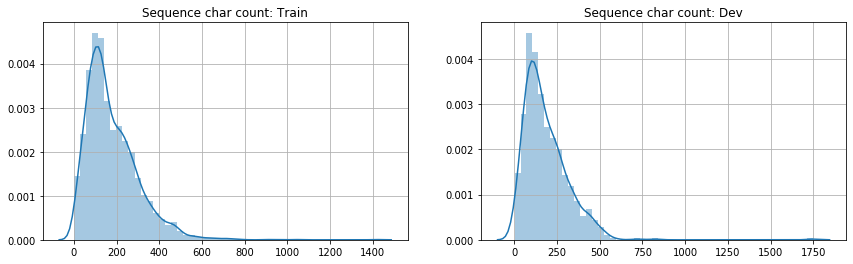

In [78]:
# Length of sequence in train data.
trainlen= [len(x) for x in train]
devlen= [len(x) for x in dev]

def plot_seq_count(lengths, data_name):
    seaborn.distplot(lengths)
    plt.title(f'Sequence char count: {data_name}')
    plt.grid(True)

plt.subplot(1, 3, 1)
plot_seq_count(trainlen, 'Train')

plt.subplot(1, 3, 2)
plot_seq_count(devlen, 'Dev')

plt.subplots_adjust(right=3.0)
plt.show()

In [79]:
print(max(trainlen))
print(max(devlen))

1417
1746


In [80]:
#ML Method Starting here

In [81]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

tf.test.is_built_with_cuda()

print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

tf.config.experimental.list_physical_devices('GPU')
#for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

# import tensorflow.keras.backend as K
# dtype = 'float16'
# K.set_floatx(dtype)
# K.set_epsilon(1e-4)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Tensorflow version 2.2.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

True
Compute dtype: float16
Variable dtype: float32


In [82]:
def split_(word): 
    return [char for char in word]

train_sentences = [[char for char in word] for word in train]
validation_sentences = [[char for char in word] for word in dev]
#test_sentences = test['sequence'].apply(lambda x: split_(x))

In [84]:
vocab_size = 8
max_length = 700
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"

tokenizer = Tokenizer(oov_token=oov_tok, num_words = vocab_size)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
print(word_index)

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type)
# del train_sentences
# del train_sequences
# gc.collect()

{'<OOV>': 1, 'h': 2, 'e': 3, 't': 4, 's': 5, 'g': 6, 'b': 7, 'i': 8}


In [85]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type)
# del validation_sentences
# del validation_sequences
# gc.collect()

In [86]:
train_padded.shape

(3199, 700)

In [163]:
#Making the labels into two classes, positive and negative
detailed_train_labels = train_labels
train_labels = [lab.split('_')[0] for lab in train_labels]

In [164]:
detailed_validation_labels = validation_labels
validation_labels = [lab.split('_')[0] for lab in validation_labels]

In [92]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train_labels = le.fit_transform(train_labels)
validation_labels = le.transform(validation_labels)
#test_labels = le.transform(test_labels)

train_labels.shape, validation_labels.shape

((3199,), (800,))

In [93]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
umap_map = {v: k for k, v in le_name_mapping.items()}
print(umap_map)

{0: 'neg', 1: 'pos'}


In [94]:
def residual_block(x, filters, dil):
    shortcut = x
    bn1 = tf.keras.layers.BatchNormalization()(x)
    a1 = tf.keras.layers.Activation("relu")(bn1)
    conv1 = tf.keras.layers.Conv1D(filters, 3, dilation_rate = dil, padding="same")(a1) #1100 filters and 9 kernel size in ProtCNN
    
    bn2 = tf.keras.layers.BatchNormalization()(conv1)
    a2 = tf.keras.layers.Activation("relu")(bn2)
    conv2 = tf.keras.layers.Conv1D(filters, 1, padding="same")(a2)
    
    x = tf.keras.layers.Add()([conv2, shortcut])
    
    return x

In [97]:
input_x = tf.keras.layers.Input(shape=700)
x = tf.keras.layers.Embedding(vocab_size, vocab_size, embeddings_initializer=tf.keras.initializers.Identity(gain=1.0), trainable=False)(input_x)
x = tf.keras.layers.Conv1D(128, 3, padding="same")(x)
x = residual_block(x, 128, 1)
x = residual_block(x, 128, 2) #4 blocks of these in ProtCNN
x = tf.keras.layers.MaxPooling1D(max_length)(x)

x = tf.keras.layers.Flatten()(x)
out = tf.keras.layers.Dense(1, activation="sigmoid")(x) 

model = tf.keras.Model(inputs=input_x, outputs=out)
#optimizer = tf.keras.optimizers.Adam(lr=1e-5)

model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 700)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 700, 8)       64          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 700, 128)     3200        embedding_1[0][0]                
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 700, 128)     512         conv1d_5[0][0]                   
____________________________________________________________________________________________

In [98]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.01, patience=5)
history = model.fit(train_padded, train_labels, epochs=25, validation_data=(validation_padded, validation_labels), verbose=2, callbacks=[es])

Epoch 1/25
100/100 - 2s - loss: 0.3447 - accuracy: 0.9022 - val_loss: 0.4404 - val_accuracy: 0.9075
Epoch 2/25
100/100 - 1s - loss: 0.1805 - accuracy: 0.9384 - val_loss: 0.3329 - val_accuracy: 0.9075
Epoch 3/25
100/100 - 1s - loss: 0.1560 - accuracy: 0.9437 - val_loss: 0.2518 - val_accuracy: 0.9075
Epoch 4/25
100/100 - 1s - loss: 0.1273 - accuracy: 0.9528 - val_loss: 0.1969 - val_accuracy: 0.9488
Epoch 5/25
100/100 - 1s - loss: 0.0914 - accuracy: 0.9675 - val_loss: 0.1401 - val_accuracy: 0.9575
Epoch 6/25
100/100 - 1s - loss: 0.1160 - accuracy: 0.9600 - val_loss: 0.1309 - val_accuracy: 0.9650
Epoch 7/25
100/100 - 1s - loss: 0.0730 - accuracy: 0.9750 - val_loss: 0.1075 - val_accuracy: 0.9700
Epoch 8/25
100/100 - 1s - loss: 0.0497 - accuracy: 0.9850 - val_loss: 0.1018 - val_accuracy: 0.9650
Epoch 9/25
100/100 - 1s - loss: 0.0537 - accuracy: 0.9809 - val_loss: 0.1097 - val_accuracy: 0.9688
Epoch 10/25
100/100 - 1s - loss: 0.0568 - accuracy: 0.9794 - val_loss: 0.1118 - val_accuracy: 0.9688

In [123]:
preds = model.predict(validation_padded)

In [124]:
mask = preds > 0.5
preds[mask] = 1
preds[~mask] = 0

In [129]:
preds = preds.reshape(-1)

In [131]:
get_performance_vals(preds, validation_labels)

True positive: 55, false positive: 19, true negative: 721, false negative: 5

MCC: 0.809992
Accuracy: 97.00%
F1 score: 0.82
Precision: 0.74
Recall: 0.92


In [140]:
preds = preds.astype('int')

In [153]:
false_neg_idx = []
false_pos_idx = []
for i in range(len(preds)):
    if (preds[i] == 0 and validation_labels[i] == 1):
        false_neg_idx.append(i)
    if (preds[i] == 1 and validation_labels[i] == 0):
        false_pos_idx.append(i)

In [155]:
false_pos_idx

[153, 297, 619, 734, 763]

In [169]:
false_pos_seqs = [dev[i] for i in false_pos_idx]

In [156]:
false_neg_idx

[24,
 92,
 96,
 125,
 126,
 176,
 224,
 235,
 260,
 320,
 425,
 462,
 469,
 519,
 525,
 603,
 608,
 651,
 684]

In [170]:
false_neg_seqs = [dev[i] for i in false_neg_idx]

In [168]:
[detailed_validation_labels[i] for i in false_neg_idx]

['pos_10_Aerolysin.txt',
 'pos_7_HlyE.txt',
 'pos_18_ETX_MTX2.txt',
 'pos_4_Tcda_Tcdb_pore.txt',
 'pos_44_Toxin_Tolip.txt',
 'pos_24_Anemone_cytotox.txt',
 'pos_31_MACPF.txt',
 'pos_4_T4BSS_DotI_IcmL.txt',
 'pos_22_Thiol_cytolysin.txt',
 'pos_9_Bac_thur_toxin.txt',
 'pos_10_Aerolysin.txt',
 'pos_31_MACPF.txt',
 'pos_46_Clenterotox.txt',
 'pos_9_Bac_thur_toxin.txt',
 'pos_3_BB_PF.txt',
 'pos_31_MACPF.txt',
 'pos_15_Gasdermin.txt',
 'pos_31_MACPF.txt',
 'pos_6_Colicin.txt']

In [174]:
with open('ss.txt', 'r') as handle:
    descs, seqs = parse_fasta(handle.read().split('\n'))

In [176]:
pdbseqs = [seq.replace(" ", "") for seq in seqs]

In [179]:
false_neg_pdbs = []
for i in range(len(pdbseqs)):
    if pdbseqs[i] in false_neg_seqs:
        false_neg_pdbs.append(descs[i])

In [180]:
false_neg_pdbs

['1A87:A:secstr',
 '1KD6:A:secstr',
 '1KFH:A:secstr',
 '1M3I:C:secstr',
 '1VCY:A:secstr',
 '1VGF:B:secstr',
 '2QP2:A:secstr',
 '2QUO:A:secstr',
 '2Y9G:A:secstr',
 '3C0M:B:secstr',
 '3OJY:A:secstr',
 '3T5O:A:secstr',
 '4MKQ:B:secstr',
 '5CNL:B:secstr',
 '5J69:A:secstr',
 '5JZH:H:secstr',
 '5JZH:K:secstr',
 '5JZH:N:secstr',
 '5JZH:I:secstr',
 '5JZH:A:secstr',
 '5JZH:L:secstr',
 '5JZH:D:secstr',
 '5JZH:B:secstr',
 '5JZH:J:secstr',
 '5JZH:E:secstr',
 '5JZH:F:secstr',
 '5JZH:C:secstr',
 '5JZH:M:secstr',
 '5JZH:G:secstr',
 '5TIB:A:secstr',
 '6MRW:N:secstr',
 '6MRW:H:secstr',
 '6MRW:D:secstr',
 '6MRW:M:secstr',
 '6MRW:K:secstr',
 '6MRW:L:secstr',
 '6MRW:A:secstr',
 '6MRW:I:secstr',
 '6MRW:B:secstr',
 '6MRW:J:secstr',
 '6MRW:E:secstr',
 '6MRW:F:secstr',
 '6MRW:C:secstr',
 '6MRW:G:secstr',
 '6OQ5:A:secstr']

In [181]:
false_pos_pdbs = []
for i in range(len(pdbseqs)):
    if pdbseqs[i] in false_pos_seqs:
        false_pos_pdbs.append(descs[i])

In [182]:
false_pos_pdbs

['2JFR:A:secstr',
 '3L81:A:secstr',
 '3TEU:A:secstr',
 '4EAE:A:secstr',
 '6G44:A:secstr']